In [167]:
from datetime import datetime, timedelta
from networkx import Graph, spring_layout, draw_networkx_nodes, get_node_attributes, draw_networkx_labels, draw_networkx_edges, draw_networkx_edge_labels
from pandas import read_csv

### Loads the full edgelist

In [79]:
# Loads the full edgelist from the games played in May 2022
interactions_df = read_csv('../data/2022_05/full_edgelist.csv')

# Converts the entries in column Timestamp into datetime objects
interactions_df['Timestamp'] = interactions_df.apply(lambda x: datetime.strptime(x['Timestamp'], '%Y-%m-%d  %H:%M:%S'), axis=1)

# # Computes the inverse of the distance
# interactions_df['inverse_distance'] = 1 / interactions_df['distance']

### Loads the dataset with interpolated positions

In [39]:
# Loads the dataset with interpolated positions from the games played in May 2022
positions_df = read_csv('../data/2022_05/interpolated_positions.csv')

# Converts the entries in column Timestamp into datetime objects
positions_df['Timestamp'] = positions_df.apply(lambda x: datetime.strptime(x['Timestamp'], '%Y-%m-%d  %H:%M:%S'), axis=1)

### Loads information about players and predation events

In [14]:
# Loads the data about the players
players_df = read_csv('../data/2022_05/Player_data.csv', sep=';')

### Example: extracts the ego network of prey and predator at the time of death

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [198]:
# The game to focus on
game_to_keep = 1

# Time window to look back after each predation event
time_window = timedelta(seconds=10)

ego_networks = []

# Loops over every predation events
for row in players_df[(players_df.Game==game_to_keep) & (players_df.Killed_by.notna())][['Player_ID', 'Killed_by']].itertuples():

    # Last timestamp the prey's position was registered
    predation_time = positions_df[(positions_df.Game==game_to_keep) & (positions_df.Player_ID==row.Player_ID)]['Timestamp'].max()

    # Empty network    
    ego_network = Graph()
    
    # Loops over all interactions involving the prey or the predator within the time window before the predation event
    for idx, interaction_df in interactions_df[(interactions_df.Game==game_to_keep)
                                               & (interactions_df.Timestamp>=predation_time-time_window) & (interactions_df.Timestamp<=predation_time)
                                               & ((interactions_df.Player_ID_1==row.Player_ID) | (interactions_df.Player_ID_2==row.Player_ID)
                                                  | (interactions_df.Player_ID_1==row.Killed_by) | (interactions_df.Player_ID_2==row.Killed_by))
                                              ][['Player_ID_1', 'Player_ID_2', 'distance']].groupby(['Player_ID_1', 'Player_ID_2']):
        
        node1 = interaction_df.Player_ID_1.iloc[0]
        role1 = players_df[(players_df.Game==game_to_keep) & (players_df.Player_ID==node1)]['Role'].iloc[0]
        ego_network.add_node(node1, Role=role1)
        
        node2 = interaction_df.Player_ID_2.iloc[0]
        role2 = players_df[(players_df.Game==game_to_keep) & (players_df.Player_ID==node2)]['Role'].iloc[0]
        ego_network.add_node(node2, Role=role2)
        
        ego_network.add_edge(node1, node2, weight=interaction_df.distance.mean())

    # Adds the new ego network to the list
    ego_networks.append((ego_network,
                         (game_to_keep,
                          time_window.total_seconds(),
                          round((predation_time - datetime(predation_time.year,predation_time.month,predation_time.day)).total_seconds()),
                          row.Killed_by,
                          row.Player_ID)))

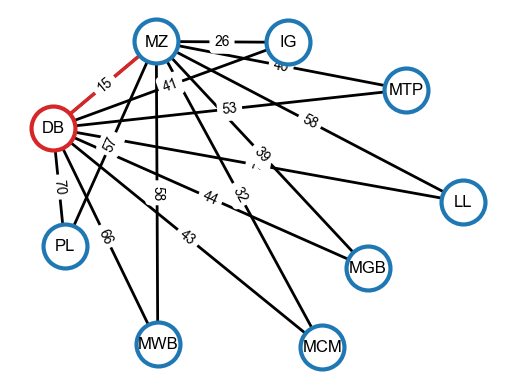

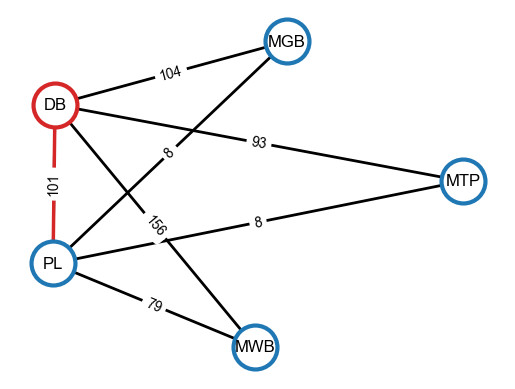

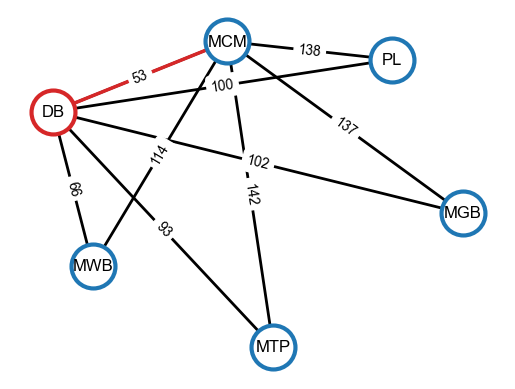

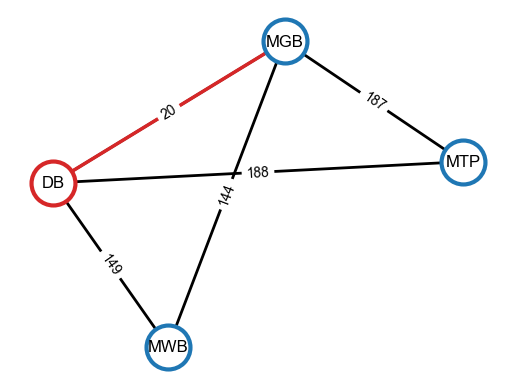

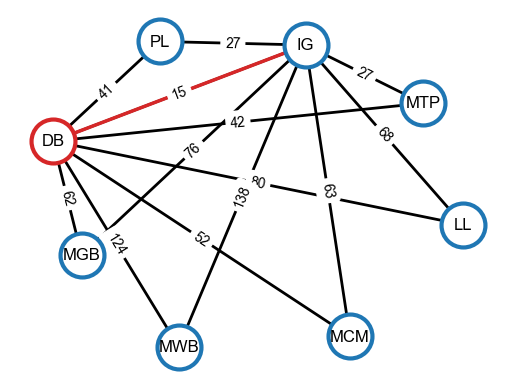

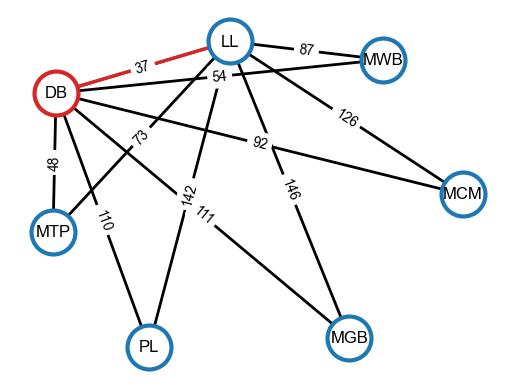

In [199]:
for ego_network, info in ego_networks:

    # Figure objects and removes frame
    fig, ax = plt.subplots()
    sns.despine(ax=ax, left=True, bottom=True)

    # Finds "good enough" positions for the nodes with a seed for reproducibility
    positions = spring_layout(ego_network, seed=7, k=20)
    
    # Plots the nodes
    draw_networkx_nodes(ego_network, pos=positions, ax=ax, edgecolors='tab:blue',   nodelist=[node[0] for node in ego_network.nodes(data='Role') if node[1]=='Prey'], node_size=1000, node_color='white', linewidths=3)
    draw_networkx_nodes(ego_network, pos=positions, ax=ax, edgecolors='tab:purple', nodelist=[node[0] for node in ego_network.nodes(data='Role') if node[1]=='Meso'], node_size=1000, node_color='white', linewidths=3)
    draw_networkx_nodes(ego_network, pos=positions, ax=ax, edgecolors='tab:red',    nodelist=[node[0] for node in ego_network.nodes(data='Role') if node[1]=='Apex'], node_size=1000, node_color='white', linewidths=3)
    draw_networkx_labels(ego_network, pos=positions, ax=ax)

    # Plots the edges
    draw_networkx_edges(ego_network, pos=positions, ax=ax, width=2)
    draw_networkx_edges(ego_network, pos=positions, ax=ax, edgelist=[(info[3], info[4])], edge_color='tab:red', width=2.5)
    draw_networkx_edge_labels(ego_network, pos=positions, ax=ax, edge_labels={(n1,n2): round(weight) for n1, n2, weight in ego_network.edges(data='weight')})
    
    # Saves and displays the ego networks
    fig.savefig('../figures/2022_05/ego_networks/game{}_timewindow{}_{}_predator{}_prey{}.pdf'.format(*info))
    plt.show()
    plt.close(fig)